<a href="https://colab.research.google.com/github/mrunalmania/Pytorch-Learning/blob/main/08_Pytorch_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch paper replicating

The goal of machine learning research paper replicating is: turn ML research paper into usable code.

In this notebook, we're going to be replicating the ViT (vision transformer) architecture with PyTorch

## 0. Get setup

Let's import the code we previously written and important libraries.

In [ ]:
import torch
import torchvision


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] torchinfo is not present, need to download this...")
  !pip install -q torchinfo
  from torchinfo import summary


try:
  from going_modular.going_modular import engine, data_setup
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] going_modular is not present, need to download....")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import engine, data_setup
  from helper_functions import download_data, set_seeds, plot_loss_curves



[INFO] torchinfo is not present, need to download this...
[INFO] going_modular is not present, need to download....
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3768, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 3768 (delta 209), reused 322 (delta 169), pack-reused 3378
Receiving objects: 100% (3768/3768), 648.93 MiB | 30.06 MiB/s, done.
Resolving deltas: 100% (2165/2165), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Downloading data

The whole goal of what we're trying to do is to replicate the ViT architecture for our foodvision mini problem.

To do that, we need some data.

Namely, the pizza, steak, sushi data.

In [ ]:
image_path = download_data(
    source= "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination = "pizza_steak_sushi"
)

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:


train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create datasets, dataloader and class_names


In [ ]:
# we need to first create transforms
from going_modular.going_modular import data_setup

In [ ]:
# create image size
IMAGE_SIZE = 224 # Comes form table 3 of ViT paper.

# Create transforms pipeline
manual_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

print(f"Mannualy created transforms: {manual_transform}")

Mannualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Create a batch size 32, paper uses 4096, but this may be too big for our smaller hardware... can scale up later.)
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize the single image

As always, adhere motto **visualize, visualize, visualize**

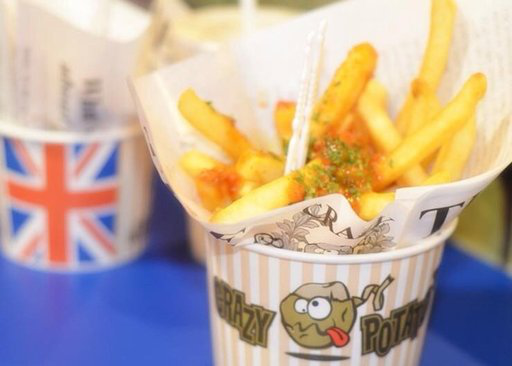

In [ ]:
from PIL import Image
import random

image_path_list = list(image_path.glob("*/*/*jpg"))

random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)

img

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# view the single image shape and label shape
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

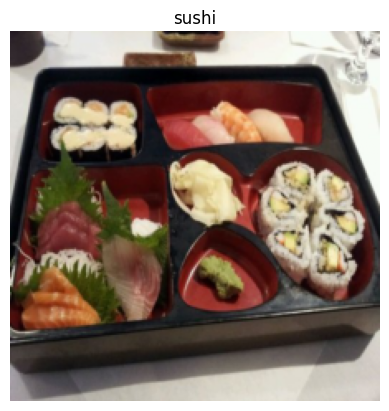

In [ ]:
# Plot the image with matplotlib
plt.imshow(image.permute(1,2,0)) # (color_channels, height, width) - > (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

 ## 3. Replicating ViT: Overview

 Looking at a whole machine learning research paper can be intimidating.

 So, in order to make it more understandable, we can break it down to smaller
 pieces.

 * **Inputs** - What goes into the model (in our case, image tensor)

 * **Outputs** - What comes out of the model/Layer/block? (in our case, we want the model to output image classification labels)

 * **Layers** - Takes an input, manipulate it with a function (for example could be self attention).

 * **Blocks** - A collection of layers
 
 * **Model** - A collection of blocks.

from numpy import block
### 3.1 ViT overview: pieces of our puzzle
* Figure 1: Visual overview of the architecture
* Four equation: math equation which define the functions of each layer/block
* Table 1/3 : DIfferent hyperparameter for the architectre/training
* Text Description (section 3.1)

### Figure 1:
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embedding = Learnable representation (start with random numbers and improve over time)

### Four equations:
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3,...image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos,..image_patch_N_pos]
```

In euqation 2&3:
pseudocode:
```python
# Equation 2:
X_outout_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3:
X_output_MLP_block = MLP_layer(LN_layer(X_output_MSA_block)) + X_output_MSA_block
```

MLP = multi-layer perceptron = a neural network with n number of layers.

MLP = one hidden layer at pre-training time
MLP = single linear layer at finetuning time.

IN pseudocode:
```python
# equation 4
y = Linear_layer(LN_layer(X_output_MLP_block))
```

Section 3.1: 
 

### Table 1:
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)





* Vit-Base, ViT largem and ViT huge are all different size of the same model architecure.

* ViTB/16 = VitBase with image path size 16X16

* Layers - the number of transformer encoder layers
* Hidden size - $D$ - the embedding siz throughout the architecture.
* MLP size - the number of hidden units/neurons in MLP
* Heads - number of multi-head self attention
* Params - Nmber of parameters


### 4. Equation 1: Split data into patches and creating the class, position, and patch embedding
  
Layer = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape - single image (224,224,3)
* Output shape - 

* Input image: $H×{W}×{C}$ 
* Output image: ${N ×\left(p^{2} ⋅ C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = height * width / p^2
* D = constant latent vector size = embedding dimensions (see table 1)


In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [ ]:
# Input shape 
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number of patches, embedding dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number of patches, embedding dimension)


### 4.2 let's turn simgle image into patches

Let's * Visualize, Visualize, Visualize* 

(-0.5, 223.5, 223.5, -0.5)

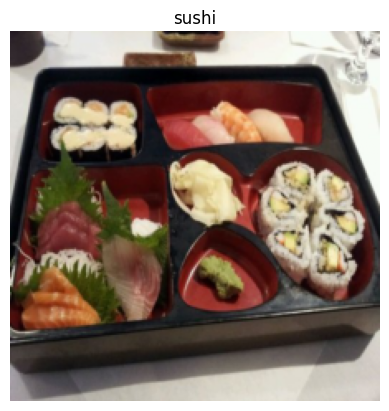

In [ ]:
# view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

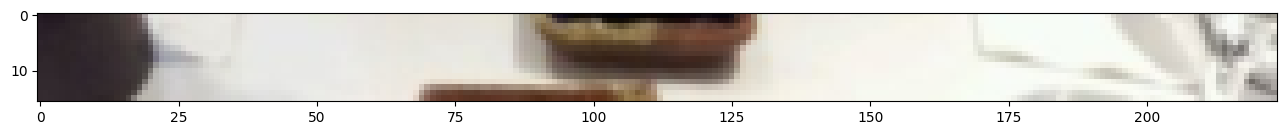

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # Convert the image to color channel last

# Index to plot the top row of the pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size ))
plt.imshow(image_permuted[:patch_size, :, :])
# plt.axis(False)

Number of patches per row: 14.0
 Patch size: 16 pixels x 16 pixels


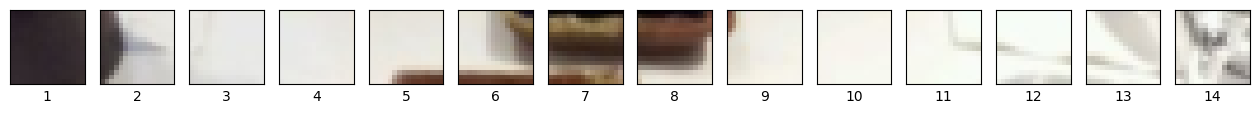

In [ ]:
# setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f"Number of patches per row: {num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axes = plt.subplots(nrows = 1,
                         ncols=img_size // patch_size, # one column for each patch
                         sharex=True,
                         sharey = True,
                         figsize = (patch_size, patch_size)
                         )
# Iterate through number of patches in top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])



In [ ]:
# Setup code to plot whole image as patches
image_size = 224
patch_size = 16
num_patches = image_size/patch_size
assert image_size%patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per col: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch Size: {patch_size} pixels X {patch_size} pixels")

 


Number of patches per row: 14.0
Number of patches per col: 14.0
Total patches: 196.0
Patch Size: 16 pixels X 16 pixels


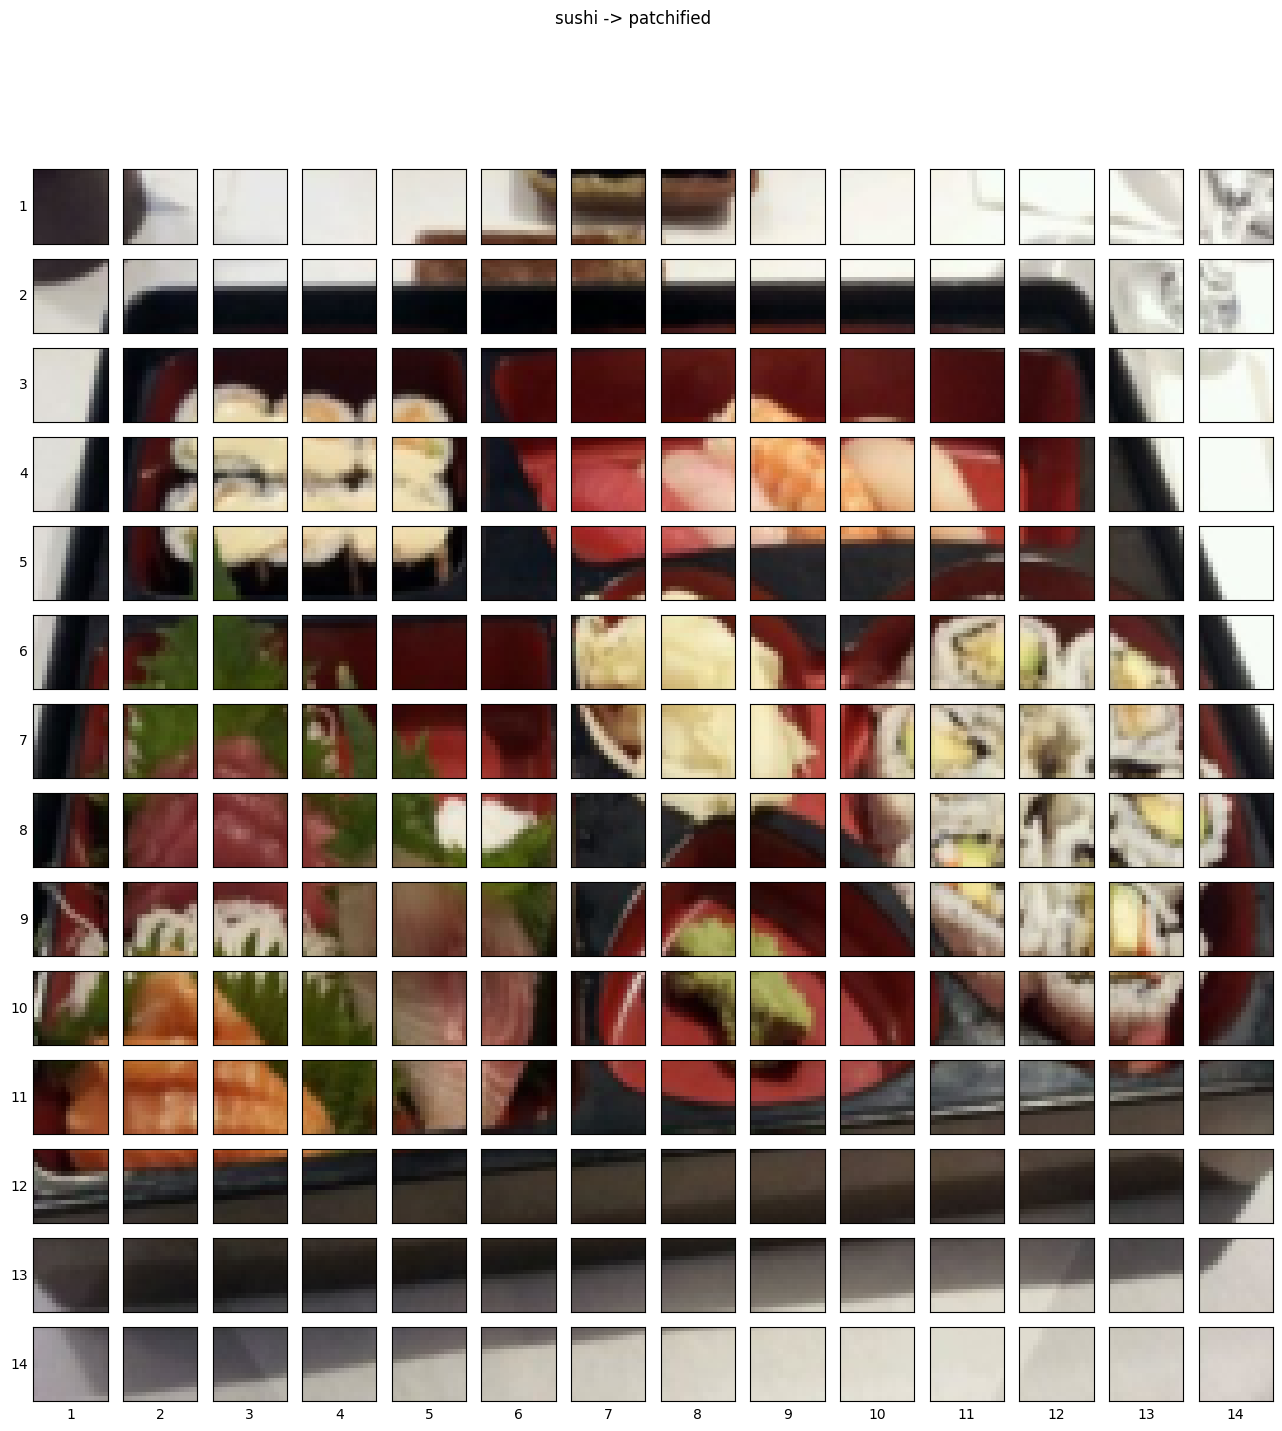

In [ ]:
# Create a series of subplots
fig, axes = plt.subplots(nrows= image_size // patch_size,
                         ncols = image_size // patch_size,
                         figsize = (patch_size, patch_size),
                         sharex = True,
                         sharey = True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0,image_size, patch_size)):
  for j, patch_width in enumerate(range(0,image_size, patch_size)):
    # Plot the permuted image on the different axes
    axes[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    # setup label information
    axes[i,j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment = "right",
                         verticalalignment = "center"
                        )
    axes[i,j].set_xlabel(j+1)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i,j].label_outer()

    # setup title for the plot
    fig.suptitle(f"{class_names[label]} -> patchified")



### 4.3 Creating image patches and turning them into 

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d` and setting the kernel size and stride values to `patch_size`
 
 

In [ ]:
# create conv2d layer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

# Set patch size
patch_size = 16

# Create a conv2d layer with hyperparameter from ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images,
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride = patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

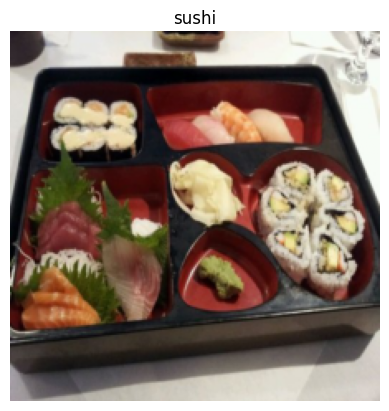

In [ ]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Pass the image through convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # We need to add batch dimension here, so we need to unsqueeze (batch_size, color_cha, height, width)
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


Now we've passes a single image to our `conv2d` layer, it's hape is:

```python
torch.size([1,768,14,14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutionala feature map from indexes: [277, 622, 474, 650, 482]


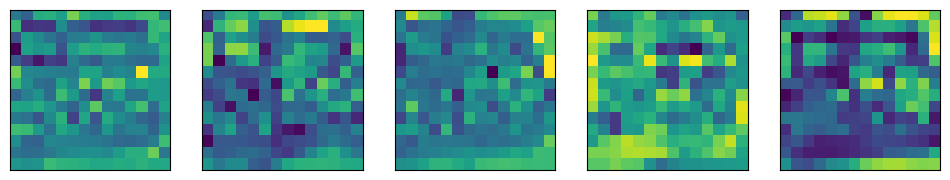

In [ ]:
# plot random convolutional feature map (embeddings)
import random
random_indexes = random.sample(range(0,758), k=5)

print(f"Showing random convolutionala feature map from indexes: {random_indexes}")


# Create plot
fig, axes = plt.subplots(nrows = 1, ncols=5, figsize=(12,12))
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor in conv2d later
  axes[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # We need to squeeze it to remove the batch dimension, and remove from grad tracking(detach)/ switching to numpy
  axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[] )

In [ ]:
# Get a single feature map(embeddngs) in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad


(tensor([[[-2.8050e-02, -1.3403e-01, -4.4946e-02, -4.5736e-02, -1.0961e-02,
            2.2206e-01, -6.0454e-02, -2.0211e-01, -6.3805e-02, -6.3856e-02,
           -4.6800e-02, -3.5670e-02, -7.6741e-02, -8.4394e-02],
          [ 6.1387e-02, -6.3800e-02, -1.3810e-01, -1.7616e-01, -5.2207e-02,
           -2.5731e-02, -1.0722e-01, -2.7233e-01, -2.9831e-01, -2.7858e-01,
           -2.6173e-01, -3.4924e-01,  8.4184e-02, -9.4547e-02],
          [ 1.5512e-01, -6.9830e-02, -1.0512e-01, -9.7682e-02, -1.0866e-01,
           -6.2832e-02, -6.3933e-02, -1.0353e-01, -1.6854e-01, -9.6437e-02,
           -4.5274e-02, -2.0167e-02, -9.5724e-02, -3.8023e-02],
          [ 2.0267e-01, -2.9736e-01, -2.1861e-01, -1.4192e-01,  1.3195e-01,
           -7.6142e-02, -1.2873e-01, -9.1009e-02, -2.3202e-01, -1.4553e-01,
           -1.1511e-01, -1.5208e-01, -4.1185e-01, -3.9045e-02],
          [ 7.9392e-02, -2.7273e-01, -1.2539e-01, -1.2063e-01,  7.6561e-03,
            1.9946e-02, -3.9350e-02, -2.2543e-01, -1.3316e-0

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've series of convolutional feature maps(patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: (batch_size, number_of_patchs, embedding_dim)

In [ ]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


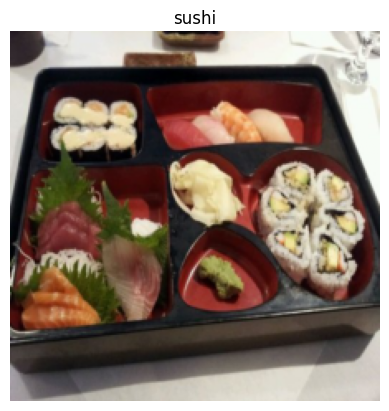

In [ ]:
# put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into featue maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)

print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


(-0.5, 195.5, 0.5, -0.5)

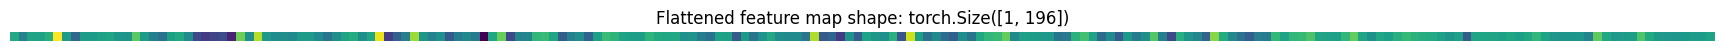

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map

# plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False) 

## 4.5 Turning the ViT patch embedding layer into a PyTorch module.

We want this module to do a few things:
1. Createa class called `PatchEmbedding` that inherits the `nn.Module`
2. Init with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the computation (e.g. pass through layer from step 3 and 4)
6. Make sure the output shape of the layer reflects the required otput shape of the patch embedding.

In [ ]:
class PatchEmbedding(nn.Module):
  # 2. Init layer with appropriate hyperparameter
  def __init__(self,
               in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()
    
    # 3. Create a layer to turn an image to embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    # 4. Create a layer to flatten the feature maps
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    self.patch_size = patch_size
  
  # 5. Define forward method to define forward computation steps
  def forward(self,x):
    # Create assertion to check are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution%patch_size ==0 , f"Input image size must be divisible by patch size, image shape {image_resolution}, patch_size: {self.patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. make sure the returned sequence embedding dimensions are in the right order.(batch_size, number_of_patches, embedding_dimension)
    x_flattened_permuted = x_flattened.permute(0,2,1)
    return x_flattened_permuted

In [ ]:
set_seeds()

# Create an instance of patch embeding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape : {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape : torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

# patchify(rand_image_tensor_bad) 

### 4.6 Creating the class token embedding
Wnat to: prepend learable class token to the start of the patch embedding

In [ ]:
patch_embedded_image

tensor([[[-0.2130,  0.0574, -0.0578,  ...,  0.1356, -0.0900,  0.0488],
         [-0.9008,  0.3143, -0.1968,  ...,  0.6907, -0.3608,  0.0836],
         [-0.9394,  0.2621, -0.2381,  ...,  0.7135, -0.4367,  0.3164],
         ...,
         [-0.8057,  0.2060, -0.2487,  ...,  0.6350, -0.4055,  0.3060],
         [-0.8490,  0.2134, -0.2510,  ...,  0.6248, -0.3679,  0.3028],
         [-0.8500,  0.2240, -0.2449,  ...,  0.6466, -0.3834,  0.3028]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
from IPython.terminal.embed import embed
# Get the batch size and the embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create a class token embedding as a lernable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class toke embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) # number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token+number_of_patchs, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2130,  0.0574, -0.0578,  ...,  0.1356, -0.0900,  0.0488],
         [-0.9008,  0.3143, -0.1968,  ...,  0.6907, -0.3608,  0.0836],
         ...,
         [-0.8057,  0.2060, -0.2487,  ...,  0.6350, -0.4055,  0.3060],
         [-0.8490,  0.2134, -0.2510,  ...,  0.6248, -0.3679,  0.3028],
         [-0.8500,  0.2240, -0.2449,  ...,  0.6466, -0.3834,  0.3028]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token+number_of_patchs, embedding_dim)


### 4.7 Creating position embedding
Want to: Create a series of 1D lernble position embeddings and to add them to the sequence of patch embeddings

In [ ]:
# View the sequence of patch embedding with prepended class_embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2130,  0.0574, -0.0578,  ...,  0.1356, -0.0900,  0.0488],
          [-0.9008,  0.3143, -0.1968,  ...,  0.6907, -0.3608,  0.0836],
          ...,
          [-0.8057,  0.2060, -0.2487,  ...,  0.6350, -0.4055,  0.3060],
          [-0.8490,  0.2134, -0.2510,  ...,  0.6248, -0.3679,  0.3028],
          [-0.8500,  0.2240, -0.2449,  ...,  0.6466, -0.3834,  0.3028]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate number of patches
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [ ]:
# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Learnable 1D positional embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
# Add the postion embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Patch and postion embedding shape : {patch_and_position_embedding.shape}")
print(f"Patch and position embedding: {patch_and_position_embedding}")

Patch and postion embedding shape : torch.Size([1, 197, 768])
Patch and position embedding: tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7870, 1.0574, 0.9422,  ..., 1.1356, 0.9100, 1.0488],
         [0.0992, 1.3143, 0.8032,  ..., 1.6907, 0.6392, 1.0836],
         ...,
         [0.1943, 1.2060, 0.7513,  ..., 1.6350, 0.5945, 1.3060],
         [0.1510, 1.2134, 0.7490,  ..., 1.6248, 0.6321, 1.3028],
         [0.1500, 1.2240, 0.7551,  ..., 1.6466, 0.6166, 1.3028]]],
       grad_fn=<AddBackward0>)


### 4.8 Putting it all together in equation 1
We've written code to tunr an image in a flattened sequence of patch embeddings
Not let's it all in one cell

In [ ]:
from typing_extensions import Required
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of the original image and get the image dimension
print(f"Image tensor shape : {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add the batch dimension
x = image.unsqueeze(0)
print(f"INput image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# 5. Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f"Class_token embedding shape: {class_token.shape}")

#7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch embedding class token shape : {patch_embedding_class_token.shape}")

# 8. Create postion embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# Add the postion embedding to patch_embedding with class_token
patch_and_position_embedding_class_token = patch_embedded_image_with_class_embedding+position_embedding

print(f"Final input tensor: {patch_and_position_embedding_class_token}")
print(f"Patch and position embedding shape: {patch_and_position_embedding_class_token.shape}")

Image tensor shape : torch.Size([3, 224, 224])
INput image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class_token embedding shape: torch.Size([1, 1, 768])
patch embedding class token shape : torch.Size([1, 197, 768])
Final input tensor: tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7870, 1.0574, 0.9422,  ..., 1.1356, 0.9100, 1.0488],
         [0.0992, 1.3143, 0.8032,  ..., 1.6907, 0.6392, 1.0836],
         ...,
         [0.1943, 1.2060, 0.7513,  ..., 1.6350, 0.5945, 1.3060],
         [0.1510, 1.2134, 0.7490,  ..., 1.6248, 0.6321, 1.3028],
         [0.1500, 1.2240, 0.7551,  ..., 1.6466, 0.6166, 1.3028]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multi-head self attention 

* Multihead self-attention: which part of the sequence should pay most attention to itself?
  * In our case, we have series of embedded image patches which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this representation/relationship.
* To replicate MSA in pytorch we can use in-buit MSA function in PyTorch.


* LayerNorm: Layer normalization (LayerNorm) is a technique to normalize the distribution of intermediate layers. and It enables smmother gradients, faster training, better generalization accuracy.
  * Normalization = Make everything have same mean and same stadard deviation
  * In pytorch - we have in-built LayerNorm function.
  It normalize values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along with embedding dimension, it's like making all of the stairs in a staircase at the same time.


In [ ]:
import torch
from torch import nn
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self attention block ("MSA block for short.")
  """
  def __init__(self, embedding_dim: int = 768,
               num_heads: int = 12,
               attention_dropout: int = 0) -> None:
    super().__init__()
    
    # Create the layer norm (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the multi-head attention layer
    self.multi_head_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
    num_heads= num_heads, dropout = attention_dropout, batch_first=True)  # is the batch_first (batch, seq, feature) -> ( batch, number_of_patches, embedding_dimestion)


  # define forward method
  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, _ = self.multi_head_attention(query=x,
                                            key=x,
                                            value=x,
                                            need_weights = False)
    return attn_output



In [ ]:
# Create an instnce MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads = 12,
                                                             attention_dropout=0)

# Pass the patch_and_postion image embedding seq through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding_class_token)
print(f"Input shape of MSA block : {patch_and_position_embedding_class_token.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block : torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding_class_token

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7870, 1.0574, 0.9422,  ..., 1.1356, 0.9100, 1.0488],
         [0.0992, 1.3143, 0.8032,  ..., 1.6907, 0.6392, 1.0836],
         ...,
         [0.1943, 1.2060, 0.7513,  ..., 1.6350, 0.5945, 1.3060],
         [0.1510, 1.2134, 0.7490,  ..., 1.6248, 0.6321, 1.3028],
         [0.1500, 1.2240, 0.7551,  ..., 1.6466, 0.6166, 1.3028]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2289, -0.1996,  0.0805,  ..., -0.4311,  0.8654, -0.4839],
         [-0.2335, -0.1742,  0.1079,  ..., -0.4302,  0.9018, -0.5193],
         [-0.2334, -0.1700,  0.1103,  ..., -0.4329,  0.9042, -0.5190],
         ...,
         [-0.2350, -0.1644,  0.1086,  ..., -0.4376,  0.9056, -0.5186],
         [-0.2351, -0.1642,  0.1088,  ..., -0.4369,  0.9064, -0.5188],
         [-0.2349, -0.1651,  0.1088,  ..., -0.4366,  0.9061, -0.5189]]],
       grad_fn=<TransposeBackward0>)

## 6. Multi-Layer perceptron block (MLP block)

* **MLP** = The MLP contains two layers with GELU non-linearity. (Section 3.1)
  * MLP = a quite broad term for block with a series of layer(s), layers can be multiple or even only one hidden layer. 
  * Layers can mean: fully connected, dense, linear, feed-forward, all are often similar names for the same thine. In pytorch they are called `torch.nn.Linear()` and just for reference in TensorFlow they might be called `tf.keras.dense()`
  * GELU - in pytoch -smoother ReLU
  * MLP number of hidden units: MLP size in Table 1.

* **Dropout** - Dropout, whem used, is applied every dense layer except qkv projections and directly after adding positional to patch embeddings. Hybrids models are trained with the exact setup as their ViT counterparts.
  * Value for dropout available in table 3.
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout.
```

In [ ]:


class MLPBlock(nn.Module):
  """ Creates a MLP block
  """
  def __init__(self,embedding_dim: int = 768,
               mlp_size: int = 3072, # Table 1. for reference.
               num_heads: int = 12,
               dropout: float = 0.1):
    super().__init__()
    
    # Create a norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p=dropout)
      )
  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) benifits for oprator fusion


In [ ]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size = 3072,
                     dropout=0.1)
# Pass output the MSABlock through MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block[0])
print(f"INput shape of Patched image through MSA block: {patched_image_through_msa_block[0].shape}")
print(f"Output shape of patched image through MLP block: {patched_image_through_mlp_block.shape}")

INput shape of Patched image through MSA block: torch.Size([197, 768])
Output shape of patched image through MLP block: torch.Size([197, 768])


In [ ]:
patched_image_through_mlp_block

tensor([[-0.0353, -0.0101,  0.1427,  ..., -0.0000, -0.1687,  0.2029],
        [-0.0960, -0.1263,  0.2732,  ..., -0.1096, -0.1387,  0.2206],
        [-0.0118, -0.0498,  0.2848,  ..., -0.0000, -0.1991,  0.2097],
        ...,
        [-0.1604, -0.0285,  0.2676,  ...,  0.1016, -0.2169,  0.2879],
        [-0.1211,  0.0269,  0.0000,  ...,  0.0341, -0.1937,  0.0804],
        [-0.0582, -0.0333,  0.2289,  ..., -0.1194, -0.1616,  0.1920]],
       grad_fn=<MulBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2289, -0.1996,  0.0805,  ..., -0.4311,  0.8654, -0.4839],
         [-0.2335, -0.1742,  0.1079,  ..., -0.4302,  0.9018, -0.5193],
         [-0.2334, -0.1700,  0.1103,  ..., -0.4329,  0.9042, -0.5190],
         ...,
         [-0.2350, -0.1644,  0.1086,  ..., -0.4376,  0.9056, -0.5186],
         [-0.2351, -0.1642,  0.1088,  ..., -0.4369,  0.9064, -0.5188],
         [-0.2349, -0.1651,  0.1088,  ..., -0.4366,  0.9061, -0.5189]]],
       grad_fn=<TransposeBackward0>)

## 7. Creating the transformer encoder

The transformer encoder is the combination of alternating blocks of MSA (equation 2) and MLP (euqation 3).

And there are residual connection between two blocks.

* Encoder = turn a sequence into lernable representation.
* Decider = go from learned representation back to some sort of sequence.
* Residual connecton : add a layer(s) input to subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)


```python
# Tranformer encoder
x_input -> MSA_BLock -> [MSA_Block_output + X_input]
 -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] ....

 


In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               attn_dropout: int = 0):
    super().__init__()

    # Create MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attention_dropout=attn_dropout)
    
    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size= mlp_size,
                              dropout=mlp_dropout)
  
  # Define forward method
  def forward(self, x):
    x = self.msa_block(x) + x # residual connection also reffered to as skip connection.
    x = self.mlp_block(x) + x # residual connection also reffered to as skip connection.

    return x
  

In [ ]:
import torchinfo
# Create a an istance for transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()

# get a summary using torchnfo.summary
summary(model = transformer_encoder_block,
                  input_size = (1,197,768), # (batch_size, number_of_patches, embedding_dimension)
                  col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
                  col_width = 20,
                  row_settings=['var_names']
                  )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a transformer encoder Layer with in-built pytorch layer.

So far we've created transformer encoder by hand.

But because of how good the Transformer erchitecture is, PyTorch has implemented ready to use Transformer Encoder layers.

In some sense , feed forward network is same as MLP.

We can create a transformer encoder layer with pure pytorch layers.

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

torch_transformer_encoder_layer



TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
torchinfo.summary(model=torch_transformer_encoder_layer,
                  input_size=(1,197,768),
                  col_names=["input_size", "output_size","num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it with a single pytorch layer.

Practice, practice, practice

Now we know how things are implemented behind the scenes, we can tweak them if necessary.

What are the benefits of using the pre-built pytorch layer:
1. Less prone to errors. (goes through a bunch of testing).
2. Potential benefits of speedups

## 8. Puttinh it all together to create ViT

In [ ]:
from torch.nn.modules.transformer import TransformerEncoderLayer
# Create a vit class
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224, # Table 3 from vit paper
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layers: int = 12, # Table 1. layers for ViT-Base
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: int = 0,
               mlp_droupout: float = 0.1,
               embedding_dropout: int = 0.1, # dropout for patch and position embedding
               num_classes: int = 1000 # number of classes in out classification problem
               ):
    super().__init__()

    # Make an assertion image size compatible with patch size

    assert img_size % patch_size == 0 , f"Image size must be divisible by patch size , image size : {img_size}, patch size: {patch_size}"


    # Calculate the number of patches (height*width/patch^2)
    self.num_patches = (img_size*img_size)//(patch_size**2)

    # Creates learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)
    
    # Create position embedding (learnable)
    self.position_embedding = nn.Parameter(data= torch.randn(1,1,embedding_dim),
                                           requires_grad=True)
    
    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)


    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    
    # Create Transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads = num_heads,
        mlp_size = mlp_size,
        mlp_dropout=mlp_droupout
     ) for _ in range(num_transformer_layers)])
    
    # MLP head (create classifier head)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features = num_classes)
    )
  

  def forward(self, x):
    # get the batch size
    batch_size = x.shape[0]

    # Creates a class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim=1) # (batch_spze, number_of_patches+1, embedding_dim)

    # Add postion embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embedding")
    x = self.embedding_dropout(x)

    # Pass out position and patch embedding to Transformer encoder
    x = self.transformer_encoder(x)

    # Ptut the 0th index logit through classifier (equation 4.)
    x = self.classifier(x[:,0]) # (whole batch zeroth index)

    return x





In [ ]:
batch_size = 32
patch_size = 16

embedding_dim = 768
class_embedding = nn.Parameter(data = torch.randn(1,1,embedding_dim))

# now we need to expand the class_embedding to all of our images in sigle batch (in our case 32)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)


torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
  

In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224)

#Create an instance of ViT with number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=3)

# pass the random image tensor to out ViT instance
vit(rand_image_tensor)

tensor([[ 1.0576,  0.8981, -0.4604]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of ViT model


In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size = (1,3, 224,224), # (batch_size, color_channel, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               1,536                True
├─PatchEmbedding (patch_embedding)                                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                           [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           

## 9. Setting up training code for our custom Vit

We've replicated ViT architecture, now let's see how it performs on our foodvision mini data.

### 9.1 Creates loss function and optimizer

The paper stats it uses adam optimizer (section 4 training and fine tuning) with $B1$ = 0.9 and $B2$ = 0.999 and a weight decay of 0.1.

Weight decay =  Weight decay is the regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique -> prevents overfitting.

In [ ]:
from torch.optim import lr_scheduler
# we need to search it in paper and use the same optimizer.
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)




### loss function

THe paper doesn't actually mention what loss function they used.

Since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our ViT model


In [ ]:
from going_modular.going_modular import engine
set_seeds()

results = engine.train(model = vit,
                       train_dataloader= train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)
results


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8685 | train_acc: 0.4062 | test_loss: 1.0754 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1174 | train_acc: 0.4492 | test_loss: 2.0454 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.8425 | train_acc: 0.3359 | test_loss: 1.0062 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5171 | train_acc: 0.2734 | test_loss: 1.0909 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.2133 | train_acc: 0.2969 | test_loss: 1.1521 | test_acc: 0.2604


{'train_loss': [3.868457794189453,
  1.1174058392643929,
  1.8424838036298752,
  1.517053872346878,
  1.213267832994461],
 'train_acc': [0.40625, 0.44921875, 0.3359375, 0.2734375, 0.296875],
 'test_loss': [1.0753854115804036,
  2.0453895330429077,
  1.0062013268470764,
  1.090929905573527,
  1.1520935694376628],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.5416666666666666,
  0.5416666666666666,
  0.2604166666666667]}

### 9.4 What our training setup is missing.

How is our training setup different to the ViT paper?

We've replicate the model architecture correctly but what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?


The main things our training implementation is missing:
Prevent underfitting
* Data - our data setup uses far less data (225  vs millions).

Prevent overfitting
* Gradient clipping - prevent gradients from getting too big.
* learning rate warmup - start with low learning rate and increase to to base LR
* learning rate decay - as your model closer to convergence, start to lower the learning rate.


Searc "pytorch [technique name]"

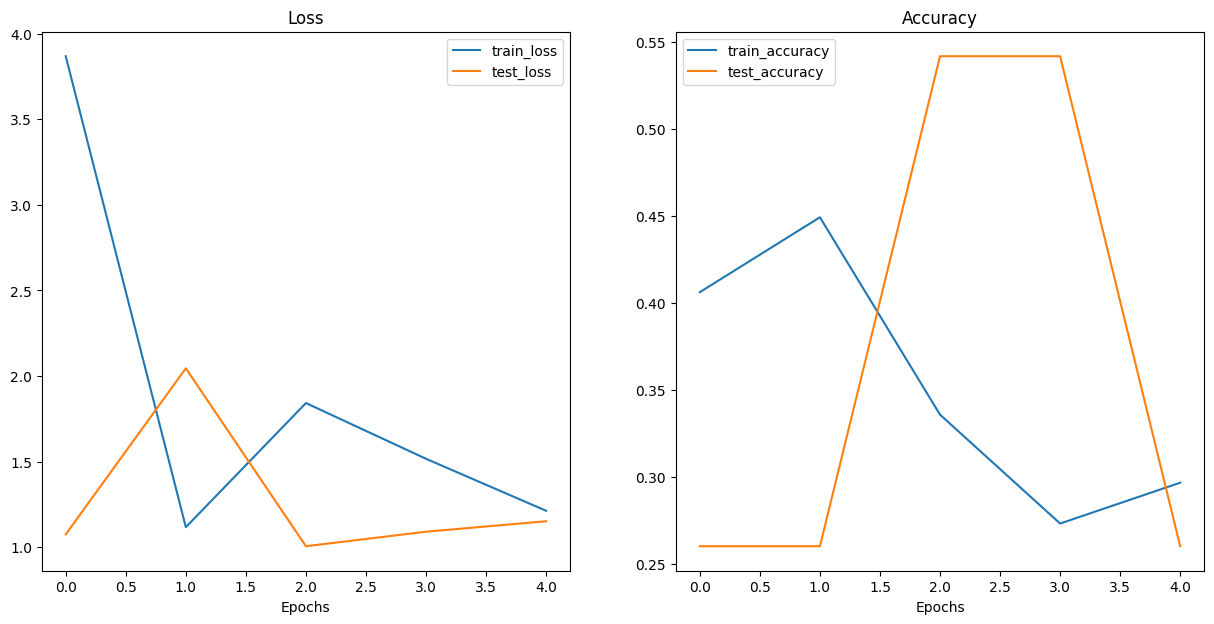

In [ ]:
### 9.5 ploting loss curves for our model

from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning, if you can use a pretrained model from a large dataset on your own problem , it's often a good place to start.

If you can find pre-trained model and use transfer earning, give it a go, it often achieves great results with little data.


**why use a pretrianed model**
* Sometimes data is limited
* Limited training resources
* Get the better results faster



In [ ]:
# The following requires torchvison0.13+

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Pretrained weights for ViT Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# update the classifier head
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features= len(class_names)).to(device)






In [ ]:
from torchinfo import summary

summary(model = pretrained_vit,
        input_size= (1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model
When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [ ]:
# Get automatic transforms from pretrained Vit weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup dataloaders 
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = 32 # could set a higher batch size because using a pretrained model.
)

train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff1a1350d60>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# 10.4 train feature extractor vit model

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# trained the classifier head of pretrained ViT

from going_modular.going_modular import engine

pretrained_vit_results = engine.train(model= pretrained_vit,
                       train_dataloader = train_dataloader_pretrained,
                       test_dataloader = test_dataloader_pretrained,
                       optimizer= optimizer,
                       loss_fn = loss_fn,
                       epochs= 10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0013 | train_acc: 1.0000 | test_loss: 0.3218 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.3265 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.3262 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.3223 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3184 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3152 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3129 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3115 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3107 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3102 | test_acc: 0.9176


### 10.5 plot the loss curves of our pretrained ViT feature extractor model


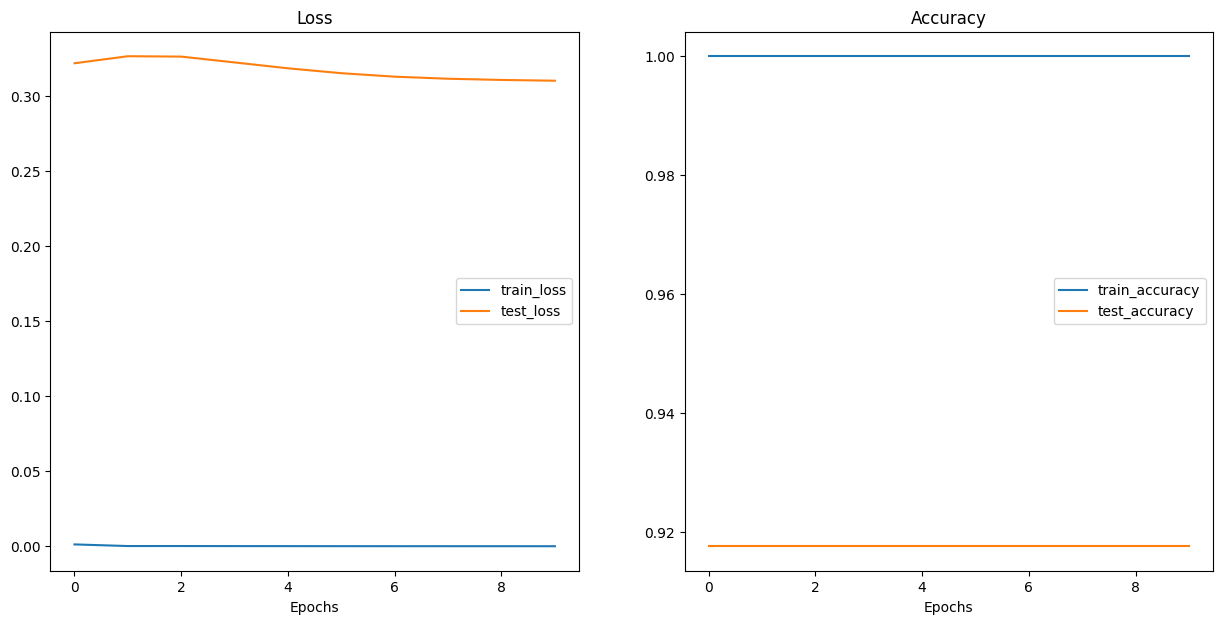

In [ ]:
from helper_functions import plot_loss_curves


plot_loss_curves(pretrained_vit_results)

### 10.6 save our best performing ViT modle

Now we've got the models that performs quite well, how about we save it to file and then check it's file size.

We want to chekc file size, because if we wanted to deploy our model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model.
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")




[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path
# Get the model size in bytes and then convert it to MB
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327 MB


## 11. Prediction on a custom image

Our pretrianed ViT gets some of the best results we've seen so far on our food vision mini problem, however, the model size is ~11x larger than our next best performing model.

Parhaps the larger model size might cause issues when we go to deploy it. (e.g. hard to deploy such a large file/might not make predictions as fast as a smaller model).

Downloading: data/pizza_steak_sushi/04-pizza-dad.jpeg


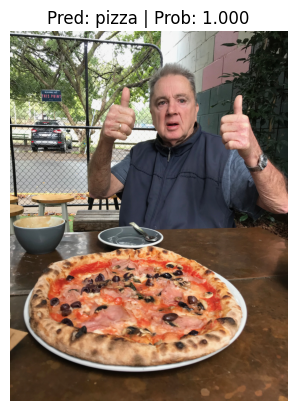

In [ ]:
import requests

from going_modular.going_modular import predictions

custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't aready exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading: {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists..")

predictions.pred_and_plot_image(model=pretrained_vit,
                                image_path = custom_image_path,
                                class_names = class_names)